In [157]:
import ncempy.io as nio
import numpy as np
from skimage.feature import blob
import matplotlib.pyplot as plt
import easygui

In [158]:
filename = easygui.fileopenbox("Select Dataset", "File-Explorer")

In [159]:
data = np.load(filename)
print(data.shape)

TypeError: expected str, bytes or os.PathLike object, not NoneType

In [ ]:
avgDP = np.average(data, axis =(0,1))       # avergae every DP from real space cordinates
avgImage = np.average(data, axis = (2,3))      # avergae every image from DP

In [ ]:
fig, ax = plt.subplots(ncols = 2)
ax[0].imshow(avgDP, cmap = "gray")
ax[0].set_title("CBED")
ax[1].imshow(avgImage, cmap ="gray")
ax[1].set_title("Real Space")

plt.show()

In [ ]:
# crop data to reduce size

data_cropped = data[:,:,25:125,20:120]
data_cropped.shape

In [ ]:
avgDPC = np.average(data_cropped, axis = (0,1))
avgImg = np.average(data_cropped, axis = (2,3))

In [ ]:
fig, ax = plt.subplots(ncols = 2)

ax[0].imshow(avgDPC, cmap ="gray")
ax[0].set_title("CBED-Cropped")
ax[1].imshow(avgImg, cmap ="gray")
ax[1].set_title("Real Space")

plt.show()

In [ ]:
np.save("cropped_data.npy", data_cropped)

# Load the cropped Dataset

In [ ]:
import easygui
import numpy as np
from skimage import feature
import matplotlib.pyplot as plt



filename = easygui.fileopenbox("Select dataset", "File-Explorer")
data = np.load(filename)
print(data.shape)

(213, 342, 100, 100)


In [ ]:
avgDP = np.average(data, axis = (0,1))
avgImg = np.average(data, axis = (2,3))
print(avgDP.shape, avgImg.shape)

(100, 100) (213, 342)


# Steps to create Virtual Reconstructions

1. Find the center of the DP
2. Create a binary mask - (1 for area to integrate, 0 for area to reject)
3. Integrate

# 1. Find the center of the DP

In [ ]:
blob = feature.blob_log(avgDP, min_sigma = 3, max_sigma = 6, threshold = 70) # blobs give a list of tuples with center and area

print(blob.shape, len(blob), blob)

row, column, area = blob[0,:]

(1, 3) 1 [[45. 49.  3.]]


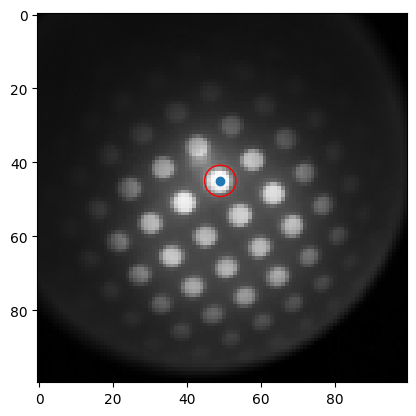

In [ ]:
fig, ax = plt.subplots()
ax.imshow(avgDP, cmap = "gray")
circle = plt.Circle((column, row), radius = area*np.sqrt(2), edgecolor ="red", fill =False)
ax.add_patch(circle)
ax.scatter(column, row)
plt.show()



# 2.Create Mask

In [ ]:
avgDP.shape

(100, 100)

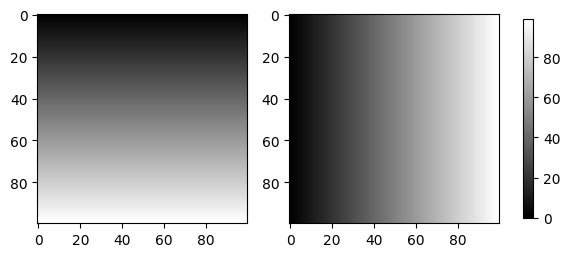

In [ ]:
x, y = np.indices((avgDP.shape[0], avgDP.shape[1]))

fig, ax = plt.subplots(ncols = 2)

im0 = ax[0].imshow(x, cmap = 'gray')
im1 = ax[1].imshow(y, cmap = 'gray')

fig.colorbar(im0, ax= ax, orientation ='vertical', fraction = 0.02)
plt.show()

In [ ]:
print(row, column)

45.0 49.0


In [ ]:
y- column

array([[-49., -48., -47., ...,  48.,  49.,  50.],
       [-49., -48., -47., ...,  48.,  49.,  50.],
       [-49., -48., -47., ...,  48.,  49.,  50.],
       ...,
       [-49., -48., -47., ...,  48.,  49.,  50.],
       [-49., -48., -47., ...,  48.,  49.,  50.],
       [-49., -48., -47., ...,  48.,  49.,  50.]], shape=(100, 100))

In [ ]:
x- row

array([[-45., -45., -45., ..., -45., -45., -45.],
       [-44., -44., -44., ..., -44., -44., -44.],
       [-43., -43., -43., ..., -43., -43., -43.],
       ...,
       [ 52.,  52.,  52., ...,  52.,  52.,  52.],
       [ 53.,  53.,  53., ...,  53.,  53.,  53.],
       [ 54.,  54.,  54., ...,  54.,  54.,  54.]], shape=(100, 100))

In [ ]:
mask_BF = (x-row)**2 + (y-column)**2 < 4**2

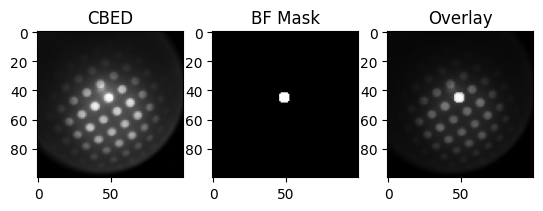

In [ ]:
fig, ax = plt.subplots(ncols = 3)

ax[0].imshow(avgDP, cmap  ='gray')
ax[0].set_title("CBED")
ax[1].imshow(mask_BF, cmap = 'gray')
ax[1].set_title("BF Mask")
ax[2].imshow(avgDP, cmap = 'gray')
ax[2].imshow(mask_BF, cmap = 'gray', alpha = 0.5)
ax[2].set_title("Overlay")
plt.show()

# 3. Create BF

In [ ]:
BF = np.zeros((avgImg.shape[0], avgImg.shape[1]))
BF

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(213, 342))

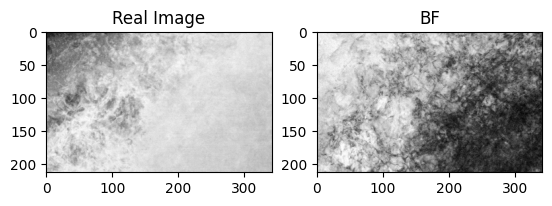

In [ ]:
for i in range(0, avgDP.shape[0]):
    for j in range(0, avgDP.shape[1]):
        if mask_BF[i,j]:
            BF = BF + data[:,:,i,j]     #  only sum inidices that are true in the mask i.e.., that fall within the mask
        

fig, ax = plt.subplots(ncols = 2)
ax[0].imshow(avgImg, cmap ='gray')
ax[0].set_title("Real Image")
ax[1].imshow(BF, cmap = "gray")
ax[1].set_title("BF")
plt.show()

# 4. Create DF Image

In [ ]:
x, y = np.indices((avgDP.shape[0], avgDP.shape[1]))

row, column, area = blob[0,:]

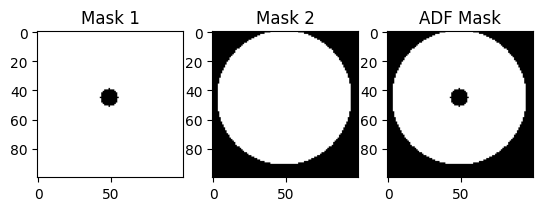

In [ ]:
mask1 = (x-row)**2 +(y-column)**2 > 6**2
mask2 = (x-row)**2 + (y-column)**2 < 46**2

ADF_mask = np.logical_and(mask1, mask2)

fig, ax = plt.subplots(ncols = 3)
ax[0].imshow(mask1, cmap ="gray")
ax[0].set_title("Mask 1")
ax[1].imshow(mask2, cmap ='gray')
ax[1].set_title("Mask 2")
ax[2].imshow(ADF_mask, cmap ="gray")
ax[2].set_title("ADF Mask")
plt.show()

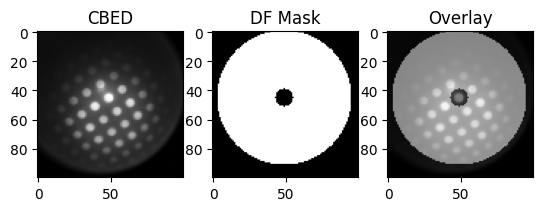

In [ ]:
fig, ax = plt.subplots(ncols =3)

ax[0].imshow(avgDP, cmap ="gray")
ax[0].set_title("CBED")
ax[1].imshow(ADF_mask, cmap ="gray")
ax[1].set_title("DF Mask")
ax[2].imshow(avgDP, cmap ="gray")
ax[2].imshow(ADF_mask, cmap ="gray", alpha = 0.5)
ax[2].set_title("Overlay")
plt.show()

In [ ]:
ADF = np.zeros((avgImg.shape[0], avgImg.shape[1]))

for i in range(0, avgDP.shape[0]):
    for j in range(0, avgDP.shape[1]):
        if ADF_mask[i,j]:
            ADF = ADF + data[:,:,i,j]        # summ all indices in data which are true in ADF mask

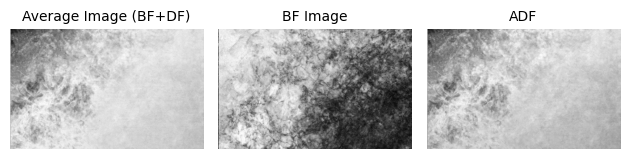

In [ ]:

fig, ax = plt.subplots(ncols =3)

ax[0].imshow(avgImg, cmap ="gray")
ax[0].set_title("Average Image (BF+DF)", fontsize = 10)
ax[0].axis("off")
ax[1].imshow(BF, cmap ="gray")
ax[1].set_title("BF Image", fontsize = 10)
ax[1].axis("off")
ax[2].imshow(ADF, cmap ="gray")
ax[2].set_title("ADF", fontsize = 10)
ax[2].axis("off")
plt.tight_layout()
plt.show()

# 5. Data from GRPC cache

In [ ]:
import easygui

In [ ]:
filename = "4D-STEM_1.npy"

data = np.load(filename)
print(data.shape)

(128, 128, 512, 512)


In [ ]:
avgDP = np.average(data, axis =(0,1)) # average over every real space x,y
avgImg = np.average(data, axis =(2,3)) # average over every dp space x,y

In [ ]:
sumDP = np.sum(data, axis = (0,1))
sumImg = np.sum(data, axis = (2,3))

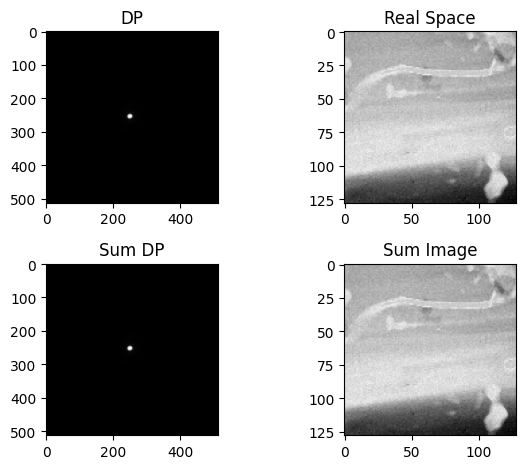

In [ ]:
fig, ax = plt.subplots(2,2)

ax[0,0].imshow(avgDP, cmap ='gray')
ax[0,0].set_title("DP")
ax[0,1].imshow(avgImg, cmap = "gray")
ax[0,1].set_title("Real Space")
ax[1,0].imshow(sumDP, cmap ="gray")
ax[1,0].set_title("Sum DP")
ax[1,1].imshow(sumImg, cmap ="gray")
ax[1,1].set_title("Sum Image")
plt.tight_layout()
plt.show()

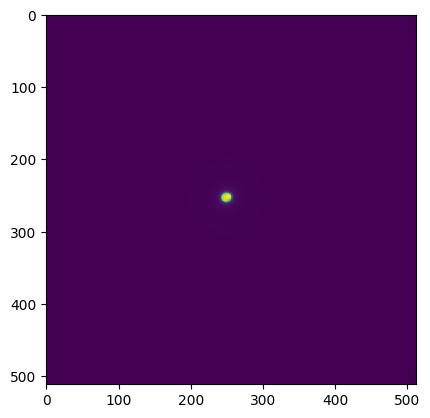

In [ ]:
plt.imshow(avgDP)

In [ ]:
data.shape

(128, 128, 512, 512)

In [ ]:
data = data[:,:,200:300,200:300]
data

array([[[[ 0,  1,  0, ...,  1,  2,  1],
         [ 0,  0,  2, ...,  0,  3,  1],
         [ 1,  1,  2, ...,  1,  3,  0],
         ...,
         [ 3,  4,  4, ...,  1,  0,  1],
         [ 3,  2,  4, ...,  1,  0,  1],
         [ 1,  6,  2, ...,  2,  1,  2]],

        [[ 1,  0,  0, ...,  2,  1,  1],
         [ 0,  0,  0, ...,  4,  2,  0],
         [ 0,  0,  1, ...,  3,  4,  2],
         ...,
         [ 7, 12, 12, ...,  0,  0,  1],
         [12, 15,  9, ...,  1,  1,  1],
         [10, 12, 21, ...,  3,  1,  1]],

        [[ 2,  2,  0, ...,  2,  1,  1],
         [ 1,  4,  2, ...,  3,  5,  1],
         [ 1,  3,  0, ...,  2,  3,  2],
         ...,
         [10,  7,  9, ...,  1,  1,  0],
         [ 8, 11, 12, ...,  1,  0,  4],
         [11, 10, 15, ...,  1,  1,  1]],

        ...,

        [[ 2,  2,  0, ...,  0,  0,  2],
         [ 1,  1,  3, ...,  3,  0,  0],
         [ 0,  2,  3, ...,  3,  3,  3],
         ...,
         [ 0,  0,  0, ...,  0,  3,  3],
         [ 1,  2,  1, ...,  1,  4,  1],
    

In [ ]:
data.shape

(128, 128, 100, 100)

In [ ]:
avgDP = np.average(data, axis =(0,1)) # average over every real space x,y
avgImg = np.average(data, axis =(2,3)) # average over every dp space x,y
sumDP = np.sum(data, axis = (0,1))
sumImg = np.sum(data, axis = (2,3))

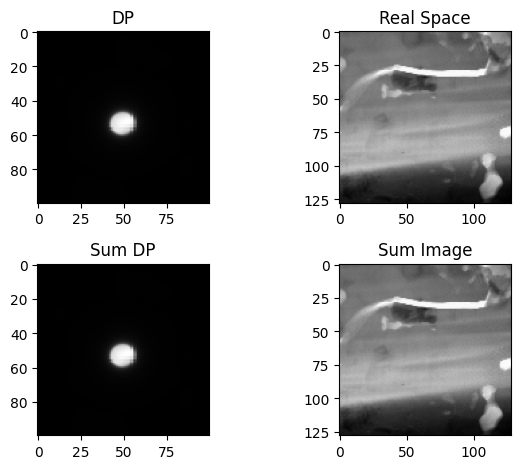

In [ ]:
fig, ax = plt.subplots(2,2)

ax[0,0].imshow(avgDP, cmap ='gray')
ax[0,0].set_title("DP")
ax[0,1].imshow(avgImg, cmap = "gray")
ax[0,1].set_title("Real Space")
ax[1,0].imshow(sumDP, cmap ="gray")
ax[1,0].set_title("Sum DP")
ax[1,1].imshow(sumImg, cmap ="gray")
ax[1,1].set_title("Sum Image")
plt.tight_layout()
plt.show()

In [ ]:
A  = np.arange(0,12,1).reshape(3,4)
A

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

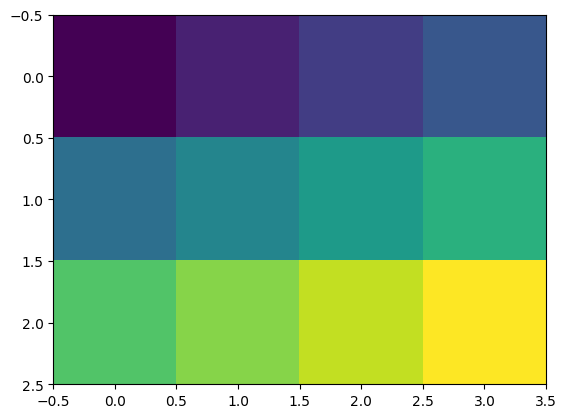

In [ ]:
plt.imshow(A)

In [ ]:
from skimage.measure import block_reduce

In [ ]:
A = np.arange(0,16,1).reshape(4,4)
A

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [ ]:
B = block_reduce(A, block_size =(2,2), func = np.sum)
B

array([[10, 18],
       [42, 50]])

In [ ]:
A = np.random.randint(0,255, size = (512,512))
A.shape

(512, 512)

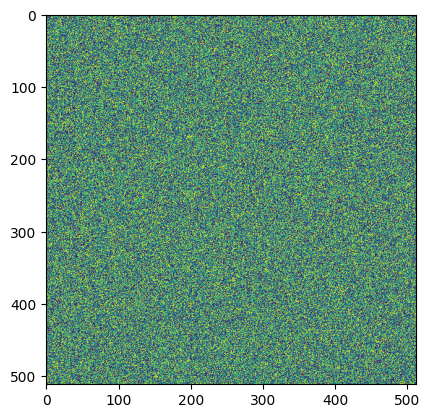

In [ ]:
plt.imshow(A)

In [ ]:
B = block_reduce(A, block_size= (4,4), func = np.mean)
B.shape

(128, 128)

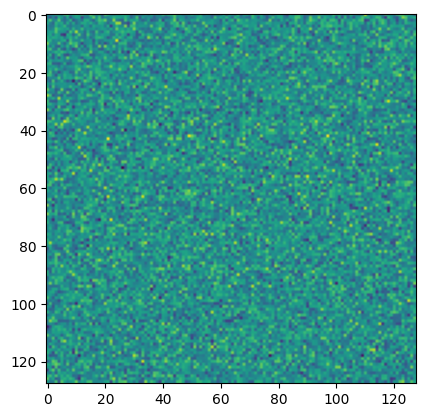

In [ ]:
plt.imshow(B)

In [ ]:
data.shape

(128, 128, 100, 100)

In [ ]:
from skimage.measure import block_reduce
from skimage import feature

In [ ]:
data = np.load("4D-STEM_1.npy")
data.shape

(128, 128, 512, 512)

In [ ]:
data_binned = block_reduce(data, block_size = (1,1,4,4), func = np.mean)
data_binned.shape

(128, 128, 128, 128)

In [ ]:
ori_image = np.average(data, axis = (2,3))
ori_DP = np.average(data, axis = (0,1))

binned_image = np.average(data_binned, axis = (2,3))
binned_DP = np.average(data_binned, axis = (0,1))

In [ ]:
ori_DP.shape

(512, 512)

In [ ]:
avg_int = np.average(ori_DP)
avg_int

np.float64(0.6701403800398111)

In [ ]:
binned_DP.shape

(128, 128)

In [ ]:
avg_int_b = np.average(binned_DP)
avg_int_b

np.float64(0.6701403800398111)

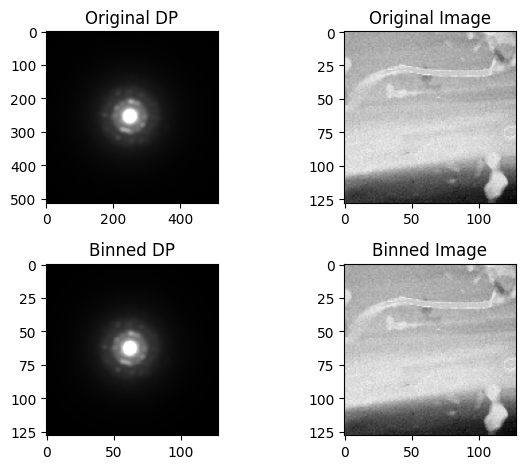

In [ ]:
fig, ax = plt.subplots(2,2)

ax[0][0].imshow(ori_DP, cmap = 'gray', vmax = avg_int*10)
ax[0][0].set_title("Original DP")
ax[0][1].imshow(ori_image, cmap = 'gray')
ax[0][1].set_title("Original Image")
ax[1][0].imshow(binned_DP, cmap = 'gray', vmax = avg_int_b*10)
ax[1][0].set_title("Binned DP")
ax[1][1].imshow(binned_image, cmap = 'gray')
ax[1][1].set_title("Binned Image")
plt.tight_layout()
plt.show()

In [ ]:
blob = feature.blob_log(binned_DP, min_sigma = 3, max_sigma = 6, threshold= 70)
blob

array([[63., 62.,  3.]])

In [ ]:
row, column, area = blob[0,:]
print(row, column, area)

63.0 62.0 3.0


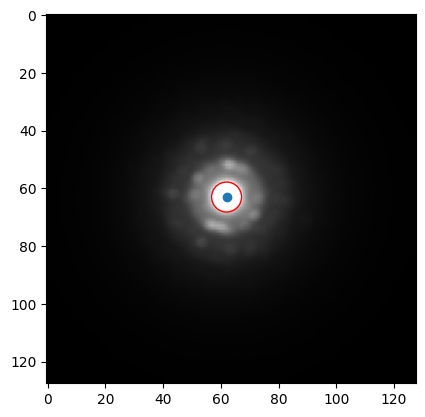

In [ ]:
fig, ax = plt.subplots()

circle = plt.Circle((column, row), radius = np.sqrt(3)*area, fill = False, edgecolor ='red')
ax.imshow(binned_DP, cmap ="gray", vmax = 10*avg_int_b)
ax.scatter(column, row)
ax.add_patch(circle)
plt.show()




(128, 128) (128, 128)


Text(0.5, 1.0, 'Overlay')

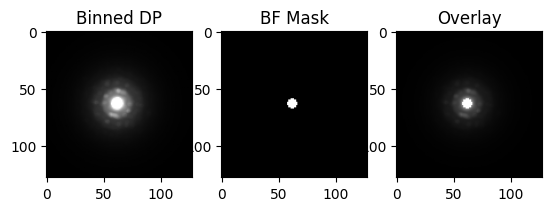

In [ ]:
# create mask

x, y = np.indices((binned_DP.shape[0], binned_DP.shape[1]))
print(x.shape, y.shape)

BF_mask = (x - row)**2 + (y- column)**2 < (np.sqrt(2)*area)**2

fig, ax = plt.subplots(ncols = 3)

ax[0].imshow(binned_DP, cmap ="gray", vmax = 10*avg_int_b)
ax[0].set_title("Binned DP")
ax[1].imshow(BF_mask, cmap = "gray")
ax[1].set_title("BF Mask")
ax[2].imshow(binned_DP, cmap ="gray", vmax = 10*avg_int_b)
ax[2].imshow(BF_mask, cmap = "gray", alpha = 0.5)
ax[2].set_title("Overlay")

Text(0.5, 1.0, 'BF Image')

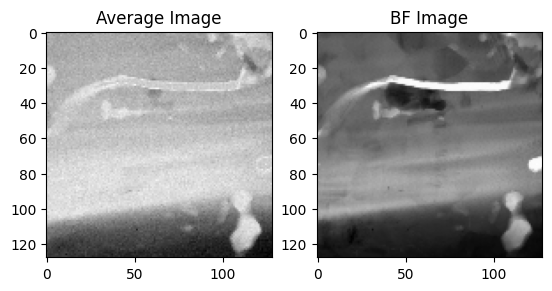

In [ ]:
BF = np.zeros((binned_image.shape[0], binned_image.shape[1]))

for i in range(0, binned_DP.shape[0]):
    for j in range(0, binned_DP.shape[1]):
        if BF_mask[i,j]:
            BF = BF + data_binned[:,:,i,j]


fig, ax = plt.subplots(ncols = 2)
ax[0].imshow(binned_image, cmap ="gray")
ax[1].imshow(BF, cmap ="gray")
ax[0].set_title("Average Image")
ax[1].set_title("BF Image")

In [ ]:
row, column

(np.float64(63.0), np.float64(62.0))

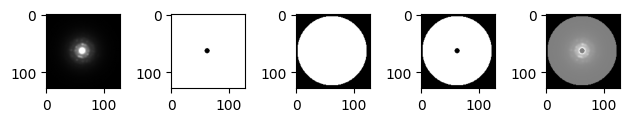

In [ ]:
DF = np.zeros((binned_image.shape[0], binned_image.shape[1]))

mask1 = (x-row)**2+ (y-column)**2 > (np.sqrt(2)*area)**2
mask2 = (x-row)**2 + (y-column)**2 < 60**2            # 62.5 = avg of row center, column center
ADF_mask = np.logical_and(mask1, mask2)

fig , ax = plt.subplots(ncols = 5)

ax[0].imshow(binned_DP, cmap = "gray", vmax = 10*avg_int_b)
ax[1].imshow(mask1, cmap = 'gray')
ax[2].imshow(mask2, cmap ="gray")
ax[3].imshow(ADF_mask, cmap = "gray")
ax[4].imshow(binned_DP, cmap ="gray", vmax = 10*avg_int_b)
ax[4].imshow(ADF_mask, cmap ="gray", alpha = 0.5)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'DF Image')

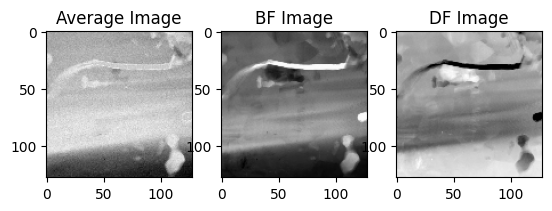

In [ ]:
ADF = np.zeros((binned_image.shape[0], binned_image.shape[1]))

for i in range(0, binned_DP.shape[0]):
    for j in range(0, binned_DP.shape[1]):
        if ADF_mask[i,j]:
            ADF = ADF + data_binned[:,:,i,j]

fig, ax = plt.subplots(ncols = 3)

ax[0].imshow(binned_image, cmap ="gray")
ax[1].imshow(BF, cmap ="gray")
ax[2].imshow(ADF, cmap ="gray")

ax[0].set_title("Average Image")
ax[1].set_title("BF Image")
ax[2].set_title("DF Image")

In [ ]:
max_diffraction_angle= 65
cal_angle = 128/max_diffraction_angle             # pixels per mrad

cal_angle

1.9692307692307693

In [ ]:
area

np.float64(3.0)

In [ ]:
inner_angle = np.sqrt(2)*area                                           # The minimum here should be greater than or equal to  np.sqrt(2)*blob_area
outer_angle = max_diffraction_angle                                     #  This should be less than or equal to max_diffraction angle
 
inner_angle_px = cal_angle*inner_angle
outer_angle_px = cal_angle*outer_angle
print(inner_angle_px, outer_angle_px)

8.35473858386567 128.0


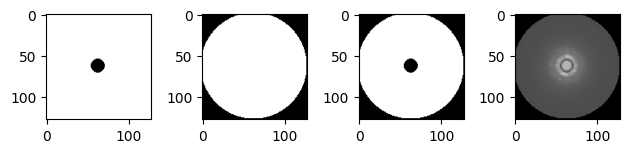

In [ ]:
mask1 = (x-row)**2 + (y-column)**2 > inner_angle_px**2
mask2 = (x-row)**2 + (y-column)**2 < (0.5*outer_angle_px)**2
ADF_mask = np.logical_and(mask1, mask2)

fig, ax = plt.subplots(ncols = 4)
ax[0].imshow(mask1, cmap=  "gray")
ax[1].imshow(mask2, cmap = "gray")
ax[2].imshow(ADF_mask, cmap ="gray")
ax[3].imshow(binned_DP, cmap = "gray", vmax = 10*avg_int_b)
ax[3].imshow(ADF_mask, cmap ="gray", alpha = 0.3)
plt.tight_layout()
plt.show()

In [ ]:
import json

In [ ]:
with open("4D-STEM_1_metadata.json", "r") as file:
    metadata = json.load(file)

print(metadata, type(metadata))

{'Acquisition date and time': '18_08_2025 11_10', 'Optical mode': 'ConvergentBeam', 'High Tension (kV)': 100.0, 'Probe current (pA)': 50.78, 'Convergence semiangle (mrad)': 2.0, 'Beam diameter (d50) (nm)': 1.28, 'FOV (um)': 1.5944102129273354, 'Pixel size (nm)': 12.46, 'Scan width (px)': 128, 'Diffraction semiangle (mrad)': 70.0, 'Diffraction angle (mrad)': 140.0, 'Camera pixel size (A^-1)': 7.387334392864964e-06, 'Scan rotation (deg)': 0, 'Rotation angle between diffraction pattern and stage XY (deg)': -199.32, 'Acquisition type': 'Camera', 'Dwell time (ms)': 0.5, 'Predicted diffraction spot diameter (px)': 'array([7.31, 7.31])', 'Camera acquisition size (px)': '(512, 512)', 'Alpha tilt (deg)': 0.0, 'Beta tilt (deg)': 0.26, 'X (um)': -217.17, 'Y (um)': -212.6, 'Z (um)': 0.03} <class 'dict'>


In [ ]:
metadata

{'Acquisition date and time': '18_08_2025 11_10',
 'Optical mode': 'ConvergentBeam',
 'High Tension (kV)': 100.0,
 'Probe current (pA)': 50.78,
 'Convergence semiangle (mrad)': 2.0,
 'Beam diameter (d50) (nm)': 1.28,
 'FOV (um)': 1.5944102129273354,
 'Pixel size (nm)': 12.46,
 'Scan width (px)': 128,
 'Diffraction semiangle (mrad)': 70.0,
 'Diffraction angle (mrad)': 140.0,
 'Camera pixel size (A^-1)': 7.387334392864964e-06,
 'Scan rotation (deg)': 0,
 'Rotation angle between diffraction pattern and stage XY (deg)': -199.32,
 'Acquisition type': 'Camera',
 'Dwell time (ms)': 0.5,
 'Predicted diffraction spot diameter (px)': 'array([7.31, 7.31])',
 'Camera acquisition size (px)': '(512, 512)',
 'Alpha tilt (deg)': 0.0,
 'Beta tilt (deg)': 0.26,
 'X (um)': -217.17,
 'Y (um)': -212.6,
 'Z (um)': 0.03}

10 30 0.9142857142857143 9.142857142857142 27.428571428571427


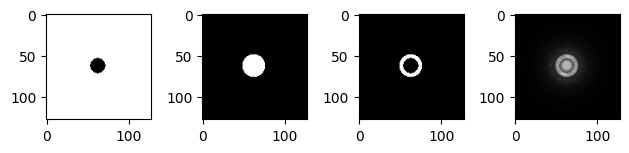

In [ ]:
max_diffraction_angle = metadata["Diffraction angle (mrad)"]

inner_angle = int(input("Enter inner angle:"))
outer_angle = int(input("Enter outer angle:"))

cal_angle = 128/max_diffraction_angle

inner_angle_px = inner_angle*cal_angle
outer_angle_px = outer_angle*cal_angle

print(inner_angle, outer_angle,cal_angle, inner_angle_px, outer_angle_px)

mask1 = (x-row)**2 + (y-column)**2 > inner_angle_px**2
mask2 = (x-row)**2 + (y-column)**2 < (0.5*outer_angle_px)**2
ADF_mask = np.logical_and(mask1, mask2)

fig, ax = plt.subplots(ncols = 4)
ax[0].imshow(mask1, cmap=  "gray")
ax[1].imshow(mask2, cmap = "gray")
ax[2].imshow(ADF_mask, cmap ="gray")
ax[3].imshow(binned_DP, cmap = "gray", vmax = 10*avg_int_b)
ax[3].imshow(ADF_mask, cmap ="gray", alpha = 0.3)
plt.tight_layout()
plt.show()



In [164]:
import tkinter as tk
import sys

main_window = tk.Tk()
var1 = tk.IntVar()
var2 = tk.IntVar()

def get_angles():
    global inner_angle
    global outer_angle
    if var1.get()>var2.get():
        print("Incorrect Angles selected: Inner angle should be greater than outer angle")
        main_window.destroy()
        sys.exit(0)
    else:
        inner_angle = var1.get()
        outer_angle = var2.get()
    main_window.destroy()

def quit_gui():
    global inner_angle
    global outer_angle
    inner_angle ="Not Defined"
    outer_angle="Not Defined"
    main_window.destroy()

frame = tk.LabelFrame(main_window, text = "Select Angular Range for ADF", padx=10, pady=10)
frame.pack(padx=5, pady=5)

in_label = tk.Label(frame, text ="Inner Angle",
                    font = ("Sans", 8, "bold"),
                    fg = "black")
in_label.grid(row=0, column=0)

in_slider = tk.Scale(frame, orient="horizontal", from_= area*cal_angle, to= 10*area*cal_angle, variable= var1)
in_slider.grid(row=0, column=1)

out_label = tk.Label(frame, text="Outer Angle",
                     font = ("Sans", 8, "bold"),
                    fg = "black")
out_label.grid(row=1,column=0)

out_slider = tk.Scale(frame, orient="horizontal", from_=10*area*cal_angle, to=metadata["Diffraction angle (mrad)"],variable = var2)
out_slider.grid(row=1, column=1)

get_btn = tk.Button(frame, text="Get Angles",
                    font =("Sans", 10, "bold"),
                    command= get_angles)
get_btn.grid(row =2, column = 0)

quit_btn = tk.Button(frame, text="QUIT",
                     font =("Sans", 10, "bold"),
                     fg ="red", command = quit_gui)
quit_btn.grid(row=2, column=2)

main_window.mainloop()

print(f"Inner Angle: {inner_angle}, Outer Angle:{outer_angle}")

Inner Angle: 4, Outer Angle:123


In [166]:
data.shape

(128, 128, 512, 512)

In [169]:
data[0][0].shape

(512, 512)

In [172]:
ar = np.random.randint(0,2,size = (2,5))
ar

array([[0, 1, 1, 0, 1],
       [1, 0, 1, 1, 0]], dtype=int32)

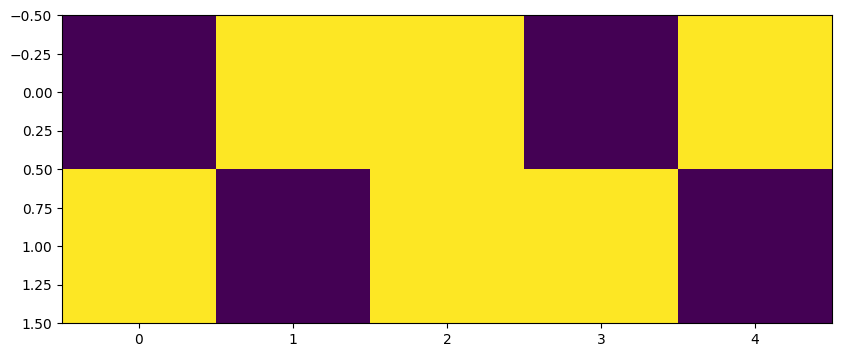

In [187]:
fig, ax = plt.subplots(figsize =(10,4))


plt.imshow(ar, cmap ="viridis")